In [40]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Modeling and evaluation tools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, ConfusionMatrixDisplay

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import warnings as wr
wr.filterwarnings('ignore')

In [22]:
churn = pd.read_csv("/Users/nicole/Desktop/DataOrbit2025/Churn_Modelling.csv")
churn = churn.dropna().drop_duplicates().drop(["RowNumber", "CustomerId", "Surname"], axis = 1)

In [26]:
# Convert appropriate columns to 'category' data type
categorical_features = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']
for col in categorical_features:
    churn[col] = churn[col].astype('category')

# Define target and features
X = churn.drop('Exited', axis=1)
y = churn['Exited']

# Define numeric features (adjust as needed)
numeric_features = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=y,
    random_state=20
)

# oversampling
ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

# Create a ColumnTransformer for preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ],
    remainder='passthrough'
)

# ------------------------------
# 2. Define Models and CV Strategy
# ------------------------------
models = {
    "Logistic Regression": LogisticRegression(random_state=20, max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(random_state=20),
    "Random Forest": RandomForestClassifier(random_state=20, n_estimators=100),
    "XGBoost": xgb.XGBClassifier(random_state=20, use_label_encoder=False, eval_metric='logloss')
}

# Use stratified 5-fold cross validation to preserve class distribution in folds
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

# ------------------------------
# 3. Apply Cross Validation
# ------------------------------
best_model_name = None
best_model = None
best_cv_score = -np.inf
for name, model in models.items():
    # Create a pipeline that first preprocesses the data and then fits the model
    pipe = Pipeline([
        ('preprocessing', preprocessor),
        ('classifier', model)
    ])
    
    # Compute cross-validated ROC AUC scores
    cv_scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring='roc_auc', n_jobs=-1)
    mean_score = cv_scores.mean()
    std_score = cv_scores.std()
    print(f"{name} | CV AUC: {mean_score:.4f} (+/- {std_score:.4f})")

    if mean_score > best_cv_score:
        best_cv_score = mean_score
        best_model_name = name
        best_model = model

print(f"\nBest model based on CV: {best_model_name} with AUC = {best_cv_score:.4f}")
print("=" * 50)


python(67794) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67795) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67796) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67797) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67798) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67799) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67800) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(67801) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


Logistic Regression | CV AUC: 0.7745 (+/- 0.0060)
Decision Tree | CV AUC: 0.9103 (+/- 0.0015)
Random Forest | CV AUC: 0.9901 (+/- 0.0021)
XGBoost | CV AUC: 0.9610 (+/- 0.0027)

Best model based on CV: Random Forest with AUC = 0.9901


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [17:43:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packa

## Random Forest

In [37]:
rf_spec = RandomForestClassifier(random_state=20, n_estimators=100)

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', rf_spec)
])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_train)

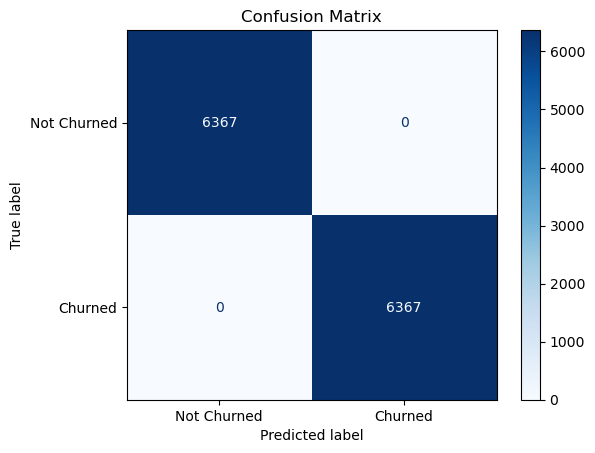

In [38]:
cm = confusion_matrix(y_train, y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

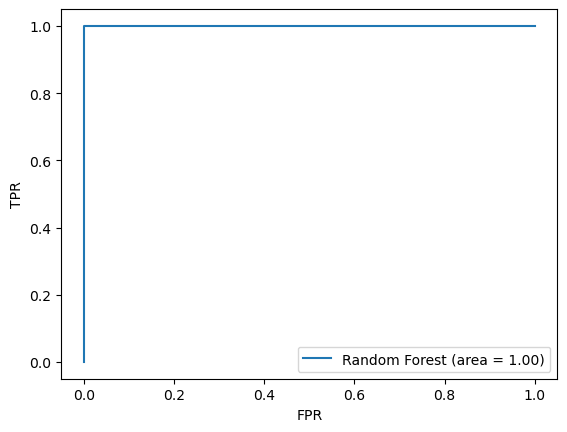

In [41]:
rf_roc_auc = roc_auc_score(y_train, y_pred_rf)
fpr, tpr, thresholds = roc_curve(y_train, rf_pipeline.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Boosted Tree

In [42]:
boost_spec = xgb.XGBClassifier(random_state=20, use_label_encoder=False, eval_metric='logloss')

boost_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', boost_spec)
])

boost_pipeline.fit(X_train, y_train)
y_pred_boost = boost_pipeline.predict(X_train)

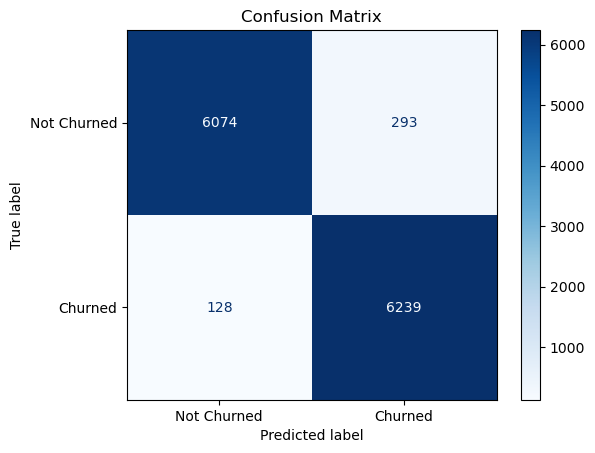

In [43]:
cm = confusion_matrix(y_train, y_pred_boost)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Churned', 'Churned'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

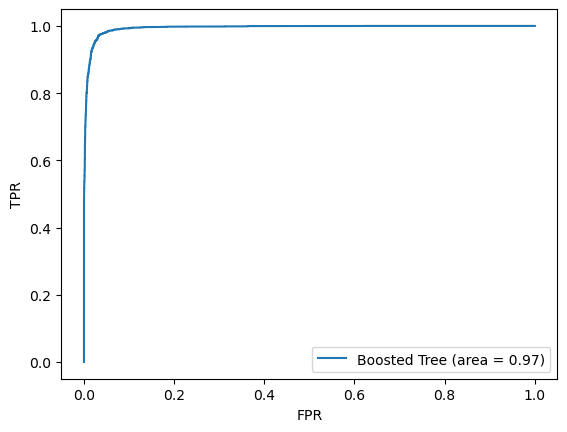

In [44]:
boost_roc_auc = roc_auc_score(y_train, y_pred_boost)
fpr, tpr, thresholds = roc_curve(y_train, boost_pipeline.predict_proba(X_train)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Boosted Tree (area = %0.2f)' % boost_roc_auc)
plt.legend(loc="lower right")
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()